# Description

In this notebook we can explore the characteristics of interaction events, such as their lengths, the associated ball displacements, etc.

# Imports

In [36]:
from pathlib import Path
import sys

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

src_path = Path.cwd().parent / "src"
if src_path not in sys.path:
    sys.path.append(str(src_path))

from Ballpushing_utils import Experiment, Fly

from utils_behavior import Processing

# Generate a Fly object

In [2]:
ExampleFly_path = Path(
    "/mnt/upramdya_data/MD/MultiMazeRecorder/Videos/231130_TNT_Fine_2_Videos_Tracked/arena2/corridor5"
)

ExampleFly = Fly(ExampleFly_path, as_individual=True)

Config loaded with the following parameters:
debugging: False
experiment_type: Ctrl
time_range: None
success_cutoff: True
success_cutoff_method: final_event
tracks_smoothing: True
chamber_radius: 50
downsampling_factor: None
generate_random: False
random_exclude_interactions: True
random_interaction_map: full
interaction_threshold: (0, 45)
gap_between_events: 1
events_min_length: 1
dead_threshold: 30
adjusted_events_normalisation: 1000
significant_threshold: 5
success_threshold: 5
aha_moment_threshold: 20
success_direction_threshold: 25
final_event_threshold: 170
final_event_F1_threshold: 100
max_event_threshold: 10
pause_threshold: 5
pause_window: 5
pause_min_duration: 2
template_width: 96
template_height: 516
padding: 20
y_crop: (74, 0)
contact_threshold: (0, 13)
gap_between_contacts: 0.5
contact_min_length: 0.5
skeleton_tracks_smoothing: False
hidden_value: 9999
Ctrl has no particular configuration.


## Get the list of interaction events using the above config parameters

In [19]:
interaction_events = ExampleFly.tracking_data.interaction_events[0][0]

interaction_events

[[np.int64(428), np.int64(887), np.int64(459)],
 [np.int64(61133), np.int64(61216), np.int64(83)],
 [np.int64(63585), np.int64(64090), np.int64(505)],
 [np.int64(64341), np.int64(64416), np.int64(75)],
 [np.int64(79792), np.int64(80074), np.int64(282)]]

In [26]:
# Take the 3rd element of each interaction event (duration) and average it

interaction_durations = [event[2] for event in interaction_events]

average_interaction_duration = sum(interaction_durations) / len(interaction_durations)

average_duration_time = average_interaction_duration / ExampleFly.experiment.fps

print(f"Average interaction duration: {average_duration_time:.2f} seconds or {average_interaction_duration:.2f} frames")

Average interaction duration: 9.68 seconds or 280.80 frames


Here we have an idea of the average duration of an interaction between the fly and the ball. Another interesting metric would be to look at the average duration of events after the event onset, as it's the critical point for UMAP

In [21]:
interaction_onsets = ExampleFly.tracking_data.interactions_onsets[0, 0]

interaction_onsets

[452, 61161, 63748, 64372, 79892]

In [27]:
# Compute the adjusted duration for each event, from the interaction onset to the end of the interaction

adjusted_interaction_durations = []

# Ensure interaction_onsets and interaction_events have the same length
if len(interaction_onsets) != len(interaction_events):
    raise ValueError("Mismatch between the number of interaction onsets and interaction events.")

for i, event in enumerate(interaction_events):
    try:
        start_time = interaction_onsets[i]
        end_time = event[1]
        if start_time is None or end_time is None:
            raise ValueError(f"Invalid start or end time for event {i}.")
        adjusted_duration = end_time - start_time
        adjusted_interaction_durations.append(adjusted_duration)
    except Exception as e:
        print(f"Error processing event {i}: {e}")

# Calculate the average adjusted interaction duration
if adjusted_interaction_durations:
    average_adjusted_interaction_duration = sum(adjusted_interaction_durations) / len(adjusted_interaction_durations)

    average_adjusted_interaction_duration_time = average_adjusted_interaction_duration / ExampleFly.experiment.fps
    print(f"Average adjusted interaction duration: {average_adjusted_interaction_duration_time:.2f} seconds or {average_adjusted_interaction_duration:.2f} frames")
else:
    print("No valid adjusted interaction durations to calculate an average.")

Average adjusted interaction duration: 7.30 seconds or 211.60 frames


So here we see on average, an event lasts 212 frames. So maximum standardized contact length should be around 200

# Test on full experiment

Flies can be quite different from one another so we're gonna generate a concatenated list of all events for one experiment.

In [29]:
ExampleExperiment_path = Path(
    "/mnt/upramdya_data/MD/MultiMazeRecorder/Videos/231130_TNT_Fine_2_Videos_Tracked/"
)
ExampleExperiment = Experiment(
    ExampleExperiment_path,
)

Config loaded with the following parameters:
debugging: False
experiment_type: Ctrl
time_range: None
success_cutoff: True
success_cutoff_method: final_event
tracks_smoothing: True
chamber_radius: 50
downsampling_factor: None
generate_random: False
random_exclude_interactions: True
random_interaction_map: full
interaction_threshold: (0, 45)
gap_between_events: 1
events_min_length: 1
dead_threshold: 30
adjusted_events_normalisation: 1000
significant_threshold: 5
success_threshold: 5
aha_moment_threshold: 20
success_direction_threshold: 25
final_event_threshold: 170
final_event_F1_threshold: 100
max_event_threshold: 10
pause_threshold: 5
pause_window: 5
pause_min_duration: 2
template_width: 96
template_height: 516
padding: 20
y_crop: (74, 0)
contact_threshold: (0, 13)
gap_between_contacts: 0.5
contact_min_length: 0.5
skeleton_tracks_smoothing: False
hidden_value: 9999
Loading fly from /mnt/upramdya_data/MD/MultiMazeRecorder/Videos/231130_TNT_Fine_2_Videos_Tracked/arena2/corridor5
Ctrl has

In [ ]:
# For each fly, get the adjusted interaction durations
adjusted_interaction_durations_all_flies = []

for fly in ExampleExperiment.flies:
    interaction_events = fly.tracking_data.interaction_events[0][0]
    interaction_onsets = fly.tracking_data.interactions_onsets[0, 0]

    # Ensure interaction_onsets and interaction_events have the same length
    if len(interaction_onsets) != len(interaction_events):
        raise ValueError("Mismatch between the number of interaction onsets and interaction events.")

    for i, event in enumerate(interaction_events):
        try:
            start_time = interaction_onsets[i]
            end_time = event[1]
            if start_time is None or end_time is None:
                raise ValueError(f"Invalid start or end time for event {i}.")
            adjusted_duration = end_time - start_time
            adjusted_interaction_durations.append(adjusted_duration)
        except Exception as e:
            print(f"Error processing event {i}: {e}")

    # Calculate the average adjusted interaction duration
    if adjusted_interaction_durations:
        average_adjusted_interaction_duration = sum(adjusted_interaction_durations) / len(adjusted_interaction_durations)

        average_adjusted_interaction_duration_time = average_adjusted_interaction_duration / ExampleFly.experiment.fps
        print(
            f"Average adjusted interaction duration: {average_adjusted_interaction_duration_time:.2f} seconds or {average_adjusted_interaction_duration:.2f} frames"
        )

        adjusted_interaction_durations_all_flies.append(adjusted_interaction_durations)
    else:
        print("No valid adjusted interaction durations to calculate an average.")

Average adjusted interaction duration: 7.30 seconds or 211.60 frames
Average adjusted interaction duration: 5.92 seconds or 171.73 frames
Average adjusted interaction duration: 5.88 seconds or 170.59 frames
Average adjusted interaction duration: 5.67 seconds or 164.32 frames
Average adjusted interaction duration: 5.57 seconds or 161.48 frames
Average adjusted interaction duration: 6.47 seconds or 187.75 frames
Average adjusted interaction duration: 6.53 seconds or 189.24 frames
Average adjusted interaction duration: 6.33 seconds or 183.61 frames
Average adjusted interaction duration: 6.45 seconds or 186.98 frames
Average adjusted interaction duration: 6.23 seconds or 180.69 frames
Average adjusted interaction duration: 6.18 seconds or 179.21 frames
Average adjusted interaction duration: 6.41 seconds or 185.86 frames
Average adjusted interaction duration: 6.21 seconds or 180.13 frames
Average adjusted interaction duration: 6.48 seconds or 187.83 frames
Average adjusted interaction durat

In [31]:
# Get the average adjusted interaction duration across all flies

if adjusted_interaction_durations_all_flies:
    all_durations_flat = [duration for sublist in adjusted_interaction_durations_all_flies for duration in sublist]
    average_adjusted_interaction_duration_all_flies = sum(all_durations_flat) / len(all_durations_flat)

    average_adjusted_interaction_duration_time_all_flies = average_adjusted_interaction_duration_all_flies / ExampleFly.experiment.fps
    print(
        f"Average adjusted interaction duration across all flies: {average_adjusted_interaction_duration_time_all_flies:.2f} seconds or {average_adjusted_interaction_duration_all_flies:.2f} frames"
    )
else:
    print("No valid adjusted interaction durations to calculate an average across all flies.")

Average adjusted interaction duration across all flies: 7.27 seconds or 210.79 frames


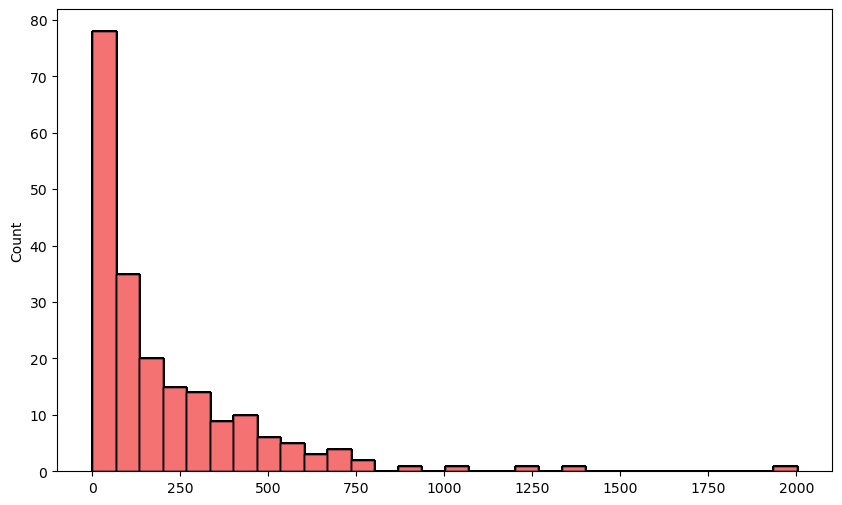

In [34]:
# Generate an histogram of the adjusted interaction durations

plt.figure(figsize=(10, 6))

sns.histplot(
    adjusted_interaction_durations_all_flies,
    bins=30,
    kde=False,
    color="blue",
)

# Remove legend
plt.legend().remove()

Data is skewed, actually although the average is 200, most interactions are found at much lower value

In [35]:
# Compute the median of the adjusted interaction durations

median_adjusted_interaction_duration = np.median(adjusted_interaction_durations_all_flies)

print(
    f"Median adjusted interaction duration across all flies: {median_adjusted_interaction_duration:.2f} frames"
)

Median adjusted interaction duration across all flies: 115.00 frames


Let's also generate some bootstrapped confidence interval of the median

In [43]:
bs_ci_median = Processing.draw_bs_ci(
    adjusted_interaction_durations_all_flies,
    func=np.median,
    n_reps=1000,
)

bs_ci_median

array([115., 115.])

In [44]:
bs_ci_mean = Processing.draw_bs_ci(
    adjusted_interaction_durations_all_flies,
    func=np.mean,
    n_reps=1000,
)
bs_ci_mean

array([210.78640777, 210.78640777])

Here we can see that the bootstrapped interval is super narrow around 115 for median and 210 for mean. Data being very skewed, it is likely that median is a better indicator, so 115 frames makes sense.

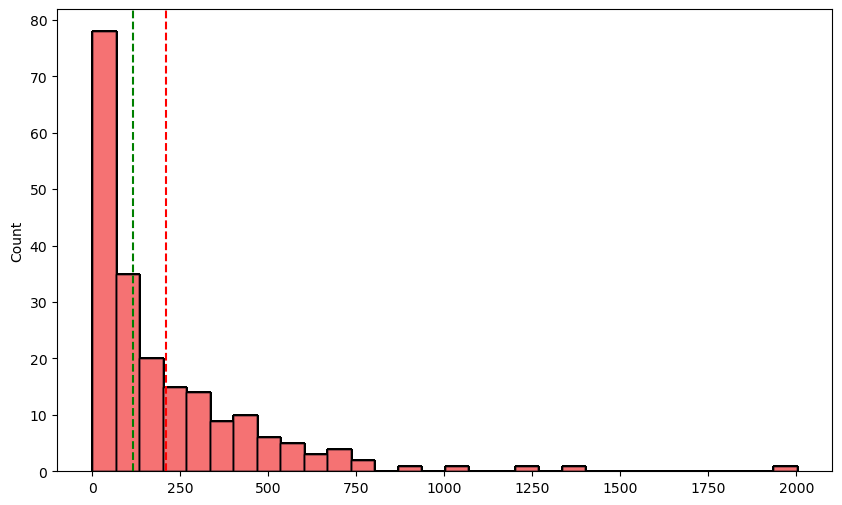

In [45]:
# Redo the histogram with the mean and median as vertical lines

plt.figure(figsize=(10, 6))

sns.histplot(
    adjusted_interaction_durations_all_flies,
    bins=30,
    kde=False,
    color="blue",
)

# Add mean and median lines

plt.axvline(
    x=average_adjusted_interaction_duration_all_flies,
    color="red",
    linestyle="--",
    label=f"Mean: {bs_ci_mean[0]:.2f} frames",
)

plt.axvline(
    x=median_adjusted_interaction_duration,
    color="green",
    linestyle="--",
    label=f"Median: {bs_ci_median[0]:.2f} frames",
)


# Remove legend
plt.legend().remove()